# Demonstration of the QLSAs workflow, following the qiskit patterns framework

In [1]:
# Set system path

from pathlib import Path
import sys


def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for d in (p, *p.parents):
        if (d / ".git").exists() or (d / "pyproject.toml").exists() or (d / "src").exists():
            return d
    return p  # fallback


repo_root = find_repo_root()
print(repo_root)

# This repo uses a "src layout" (the Python package lives in <repo>/src/qlsas),
# but the repo is not installed as a package. Add <repo>/src to sys.path.
src_dir = repo_root / "src"
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Also add the repo root so you can import top-level modules like
# `linear_systems_problems.random_matrix_generator`.
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

/Users/adrianharkness/QCOL_COPT/HHL/QLSAs


In [2]:
# Import QLSAs modules

from qlsas.qlsa.hhl import HHL
from qlsas.data_loader import StatePrep
from qlsas.transpiler import Transpiler
from qlsas.executer import Executer
from qlsas.post_processor import Post_Processor
from qlsas.solver import QuantumLinearSolver
from qlsas.refiner import Refiner
from linear_systems_problems.random_matrix_generator import generate_problem

# Import other modules
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

%config InlineBackend.figure_format = "retina"

## Step 0: **Define** the (classical) problem

In [3]:
prob = generate_problem(n=32, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]

A  = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

print(f"A: {A}")
print()
print(f"b: {b}")
print()
print(np.linalg.eigvalsh(A))

A: [[ 4.91559363e-01  3.80252637e-02  4.89503029e-17 ... -4.64254065e-02
  -1.54916584e-16  1.92127476e-02]
 [ 3.80252637e-02  3.59822713e-01 -4.92284297e-17 ... -1.40175867e-16
  -7.45379613e-17  1.76192887e-03]
 [ 4.89503029e-17 -4.92284297e-17  3.98740210e-01 ...  2.50870303e-16
   2.36692786e-02 -3.90768043e-17]
 ...
 [-4.64254065e-02 -1.40175867e-16  2.50870303e-16 ...  5.58894231e-01
   1.02420165e-16  5.61815977e-17]
 [-1.54916584e-16 -7.45379613e-17  2.36692786e-02 ...  1.02420165e-16
   5.10919463e-01  5.11057850e-18]
 [ 1.92127476e-02  1.76192887e-03 -3.90768043e-17 ...  5.61815977e-17
   5.11057850e-18  3.46029955e-01]]

b: [ 0.09016874 -0.10265272  0.16694162  0.07241834  0.44183625 -0.1876702
  0.10258693 -0.22995711 -0.12528504  0.12094732 -0.47073364 -0.15374502
 -0.17163946 -0.03537842  0.00556788 -0.16075951 -0.15641436 -0.06005417
  0.01854396 -0.21442375 -0.00347768 -0.11934269 -0.04675718 -0.08489916
  0.19291747  0.22804872 -0.20216868 -0.20627538  0.04830592  0.13

## Step 1: **Map** problem to quantum circuits and operators

In [4]:
hhl = HHL(
    state_prep = StatePrep(method='default'),
    readout = 'measure_x', # 'measure_x' or 'swap_test'
    #swap_test_vector = np.ones(len(b)) / np.linalg.norm(np.ones(len(b))),
    num_qpe_qubits = int(math.log2(len(b))),
    t0 = 1) #2 * np.pi)

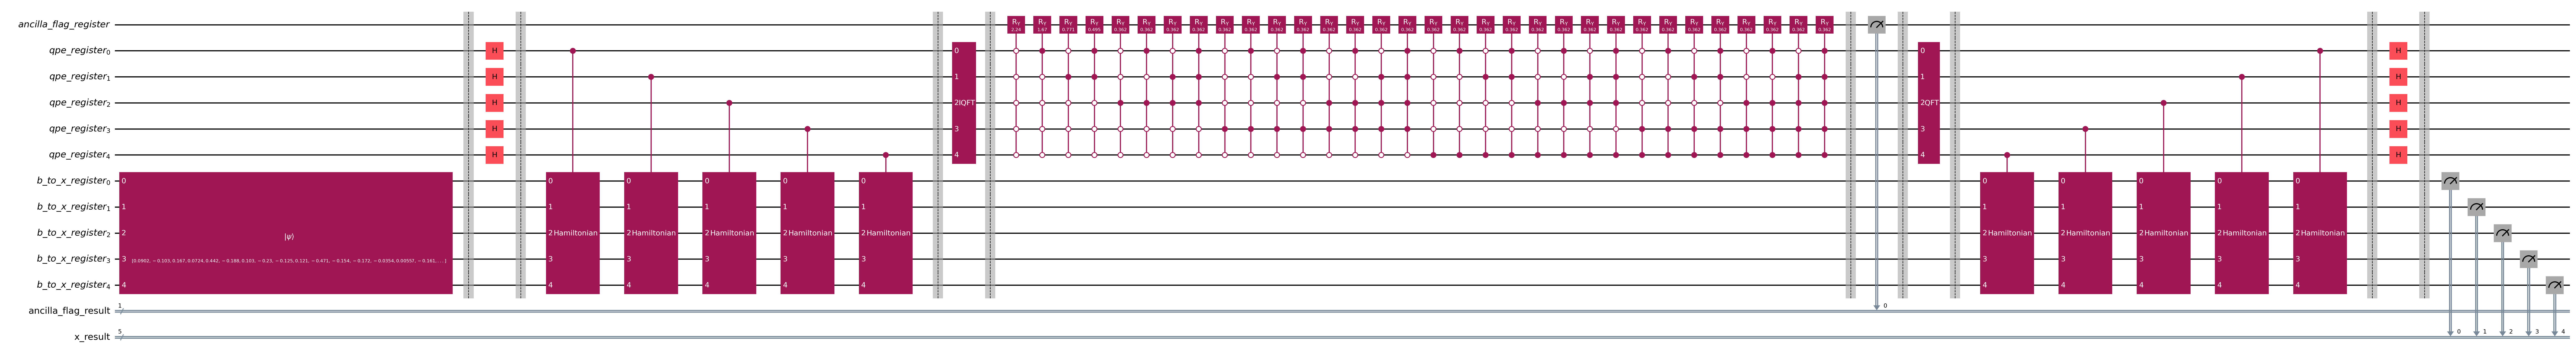

In [5]:
hhl_circuit = hhl.build_circuit(A, b)
hhl_circuit.draw(output='mpl', fold=-1)

## Step 2: **Optimize** for target hardware

In [6]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_boston')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_miami')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [7]:
# Define a backend

# use a specific hardware backend
# backend = service.backend("ibm_boston")

# or use the least busy backend
# backend = service.least_busy(operational=True, min_num_qubits=hhl_circuit.num_qubits)
# print("Backend: ", backend)

# or use a simulator
# noiseless:
backend = AerSimulator()

# noisy:
# Add depolarizing error to all single qubit u1, u2, u3 gates
# noise_model = NoiseModel()
# error_prob = .05
# error = depolarizing_error(error_prob, 1)
# noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
# backend = AerSimulator(noise_model=noise_model)

In [8]:
# Transpile the circuit

transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
transpiled_hhl_circuit = transpiler.optimize()

print(f"2q-depth:        {transpiled_hhl_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size:         {transpiled_hhl_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_hhl_circuit.count_ops()}")

2q-depth:        9948
2q-size:         10340
Operator counts: OrderedDict([('cu', 6800), ('ccx', 4440), ('cp', 2260), ('cx', 1280), ('p', 1138), ('u', 98), ('u3', 87), ('h', 20), ('barrier', 9), ('x', 6), ('measure', 6), ('initialize', 1)])


## Step 3: **Execute** on target hardware

In [9]:
executer = Executer()

result = executer.run(
    transpiled_circuit = transpiled_hhl_circuit, 
    backend = backend,
    shots = 100
    )

>>> Job ID: 224cdb16-cfa9-4f91-ac5f-b28678a2f22b
>>> Job Status: DONE      


## Step 4: **Process** result to obtain classical solution

In [10]:
processor = Post_Processor()
solution, success_rate, residual = processor.process_tomography(result, A, b)

total shots: 100
num_successful_shots: 72
success rate: 0.72
solver residual: 0.4344045455020769


## Wrapping steps 1-4 together in a solver:

In [11]:
hhl_solver = QuantumLinearSolver(
    qlsa = hhl,
    backend = backend,
    target_successful_shots = 1000,
    shots_per_batch = 5000,
    optimization_level = 3,
    executer = executer,
    post_processor = processor,)
    #mode = "session")

## Integrate **Iterative Refinement** to improve accuracy

IR Iteration: 0
>>> Job ID: 40bb9ba2-bb0d-4763-a17a-26a23c71f18d
>>> Job Status: DONE      
  residual: 0.3642, error: 0.4770, alpha: 1.6458

IR Iteration: 1
>>> Job ID: 6e002879-57a2-4dd2-bea3-cac89d14f264
>>> Job Status: DONE      
  residual: 0.1593, error: 0.1784, alpha: 1.8411

IR Iteration: 2
>>> Job ID: d5ecfbce-8075-41c9-b946-4a8ea18978e9
>>> Job Status: DONE      
  residual: 0.0792, error: 0.1011, alpha: 1.4125

IR Iteration: 3
>>> Job ID: a438c4e9-f22c-494d-8938-7b89822ff8b6
>>> Job Status: DONE      
  residual: 0.0420, error: 0.0503, alpha: 1.5774



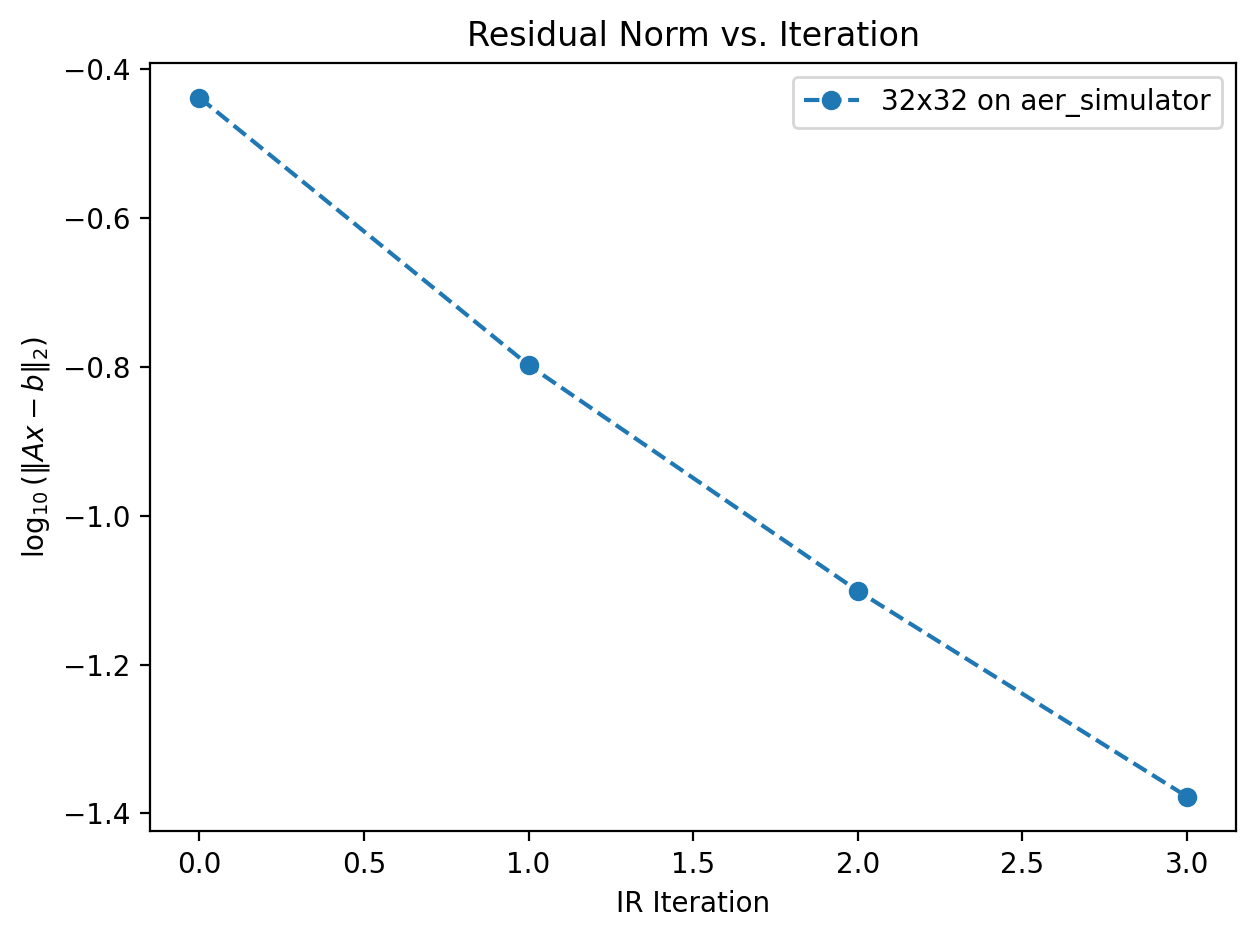

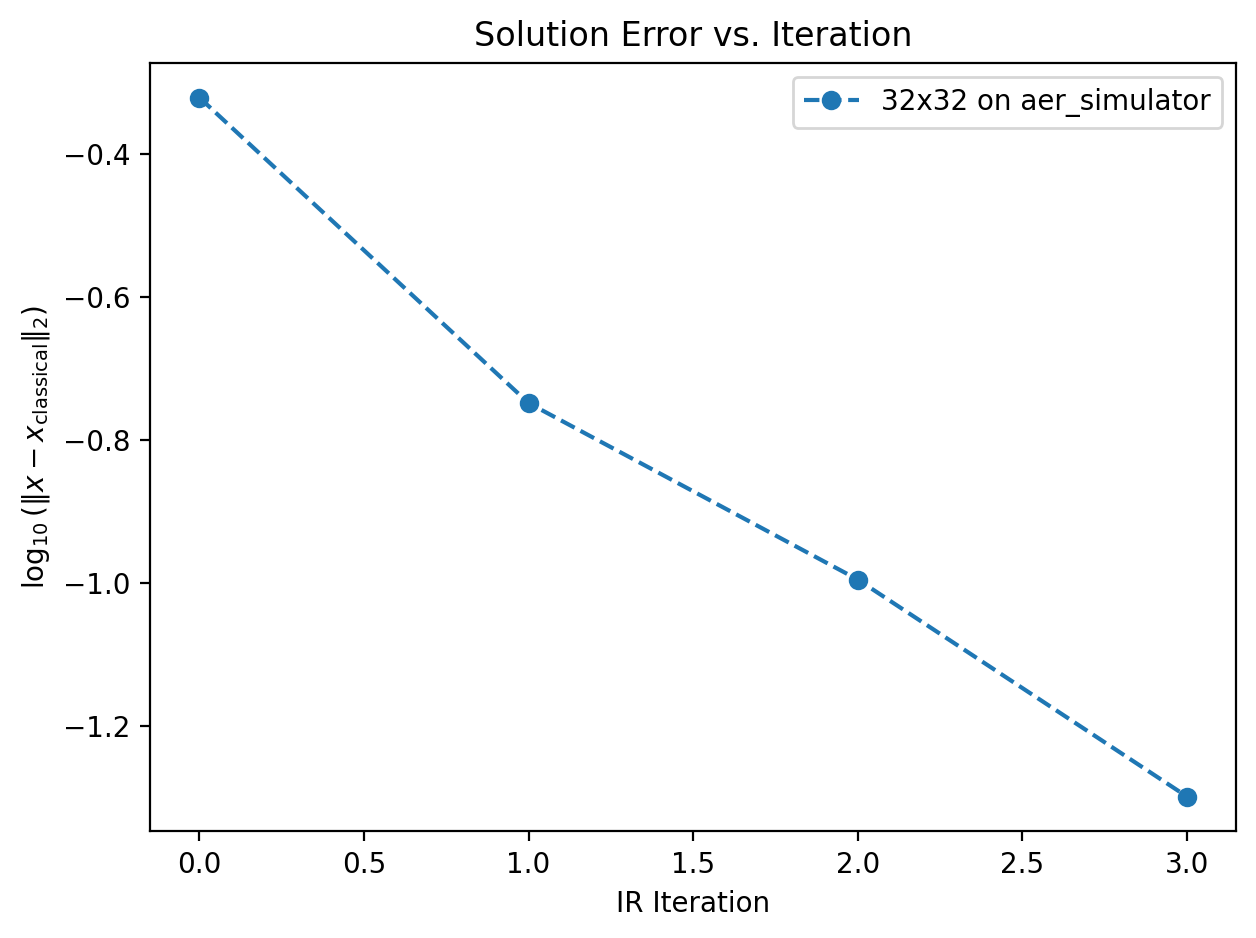

In [12]:
refiner = Refiner(A = A, b = b, solver = hhl_solver)
refined_solution = refiner.refine(precision = 1e-9, max_iter = 3, plot=True)

## Experiments

In [19]:
t0_values = np.linspace(0, 2 * np.pi, 30)
success_rates = []
residual_errors = []

prob = generate_problem(n=16, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]
A = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

for t0 in t0_values:
    if np.isclose(t0, 0.0):
        # t0=0 causes divide-by-zero in phase-to-eigenvalue mapping
        success_rates.append(np.nan)
        residual_errors.append(np.nan)
        continue

    hhl = HHL(
        state_prep=StatePrep(method="default"),
        readout="measure_x",
        num_qpe_qubits=int(math.log2(len(b))),
        t0=t0,
    )

    hhl_circuit = hhl.build_circuit(A, b)
    transpiler = Transpiler(circuit=hhl_circuit, backend=backend, optimization_level=3)
    transpiled_hhl_circuit = transpiler.optimize()

    result = executer.run(
        transpiled_circuit=transpiled_hhl_circuit,
        backend=backend,
        shots=100,
    )

    solution, success_rate, residual = processor.process_tomography(result, A, b)
    success_rates.append(success_rate)

    residual_errors.append(residual)

>>> Job ID: b4b68e59-bb65-494a-b7be-309cd6f320ad
>>> Job Status: DONE      
total shots: 100
num_successful_shots: 85
success rate: 0.85
solver residual: 0.5397434912097385
>>> Job ID: ebfad11c-e543-4cd6-a6d9-a902b9dbf408
>>> Job Status: DONE      
total shots: 100
num_successful_shots: 76
success rate: 0.76
solver residual: 0.5392604294810966
>>> Job ID: ba885a4a-3821-40e4-8782-26a981d38ddd
>>> Job Status: DONE      
total shots: 100
num_successful_shots: 79
success rate: 0.79
solver residual: 0.5706043843102735
>>> Job ID: 583e693d-8b5b-4ab7-832e-3d4dfc958b32
>>> Job Status: DONE      
total shots: 100
num_successful_shots: 74
success rate: 0.74
solver residual: 0.5090393620668628
>>> Job ID: fc3bff06-55dd-4651-b245-2aad375f450b
>>> Job Status: DONE      
total shots: 100
num_successful_shots: 76
success rate: 0.76
solver residual: 0.5646582917876883
>>> Job ID: 3d21670d-7b1d-4e88-85c4-5c0b09b7d2f9
>>> Job Status: DONE      
total shots: 100
num_successful_shots: 68
success rate: 0.6

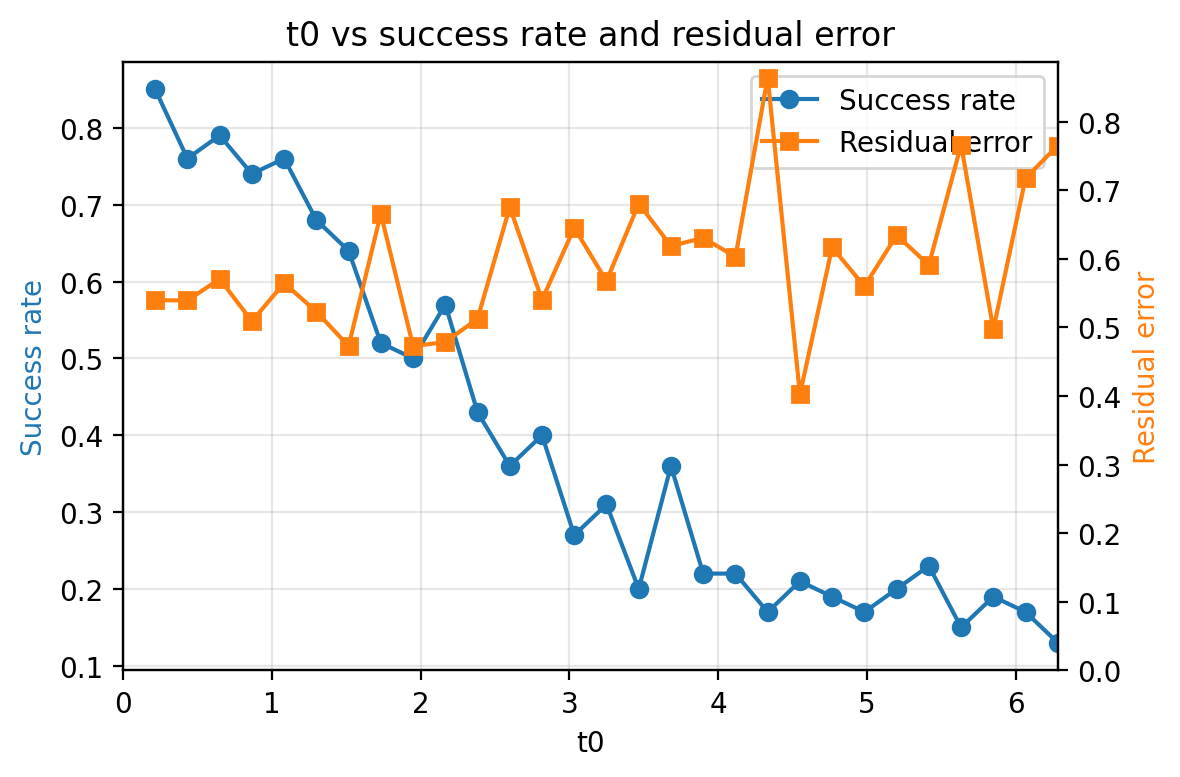

In [20]:
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(t0_values, success_rates, marker="o", color="C0", label="Success rate")
ax1.set_xlabel("t0")
ax1.set_ylabel("Success rate", color="C0")
ax1.set_xlim(0, 2 * np.pi)
#ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(t0_values, (residual_errors), marker="s", color="C1", label="Residual error")
ax2.set_ylabel("Residual error", color="C1")
ax2.set_ylim(bottom=0)

lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels)

ax1.set_title("t0 vs success rate and residual error")
plt.tight_layout()
plt.show()

In [21]:
iterations = 15          # number of IR iterations to plot (0..iterations-1)
n = 64
max_qpe_qubits = 8      # sweep num_qpe_qubits = 1..max_qpe_qubits

# rows: qpe qubits, cols: IR iteration
residuals = np.full((max_qpe_qubits, iterations), np.nan, dtype=float)

prob = generate_problem(n=n, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]
A = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

for qpe_qubits in range(1, max_qpe_qubits + 1):
    print(f"================num_qpe_qubits: {qpe_qubits}=================")
    solver = QuantumLinearSolver(
        qlsa=HHL(
            state_prep=StatePrep(method="default"),
            readout="measure_x",
            num_qpe_qubits=qpe_qubits,
            t0=2 * np.pi,
        ),
        backend=AerSimulator(),
        target_successful_shots=1000,
        shots_per_batch=5000,
        optimization_level=3,
        executer=executer,
        post_processor=processor,
    )

    refiner = Refiner(A=A, b=b, solver=solver)
    refined_solution = refiner.refine(precision=1e-20, max_iter=iterations - 1, plot=False)

    r = np.asarray(refined_solution["residuals"], dtype=float)
    residuals[qpe_qubits - 1, : len(r)] = r

# heatmap of log10 residuals
log_residuals = np.log10(np.maximum(residuals, 1e-16))

================num_qpe_qubits: 1=================
IR Iteration: 0
>>> Job ID: b670ddae-c643-426e-961d-3df11107fa77
>>> Job Status: DONE      
  residual: 0.2891, error: 0.2200, alpha: 2.8381

IR Iteration: 1
>>> Job ID: c1c1bcb1-defe-47c8-92cc-c65026ece32d
>>> Job Status: DONE      
  residual: 0.0890, error: 0.1002, alpha: 1.0378

IR Iteration: 2
>>> Job ID: 887dae65-6bbe-4389-a9be-76eaed23a965
>>> Job Status: DONE      
  residual: 0.0349, error: 0.0406, alpha: 0.9072

IR Iteration: 3
>>> Job ID: 0f6183fc-38cb-4476-9718-db5770721fc2
>>> Job Status: DONE      
  residual: 0.0141, error: 0.0224, alpha: 0.5791

IR Iteration: 4
>>> Job ID: c77aca00-ff2c-494d-a539-164d8b8c2d90
>>> Job Status: DONE      
  residual: 0.0072, error: 0.0122, alpha: 0.5816

IR Iteration: 5
>>> Job ID: 11e43cbe-4072-4948-9abb-ae9c76fe6e4a
>>> Job Status: DONE      
  residual: 0.0040, error: 0.0078, alpha: 0.5613

IR Iteration: 6
>>> Job ID: 9f6b9865-cc92-4a2c-b905-0621a39045c9
>>> Job Status: DONE      
  res

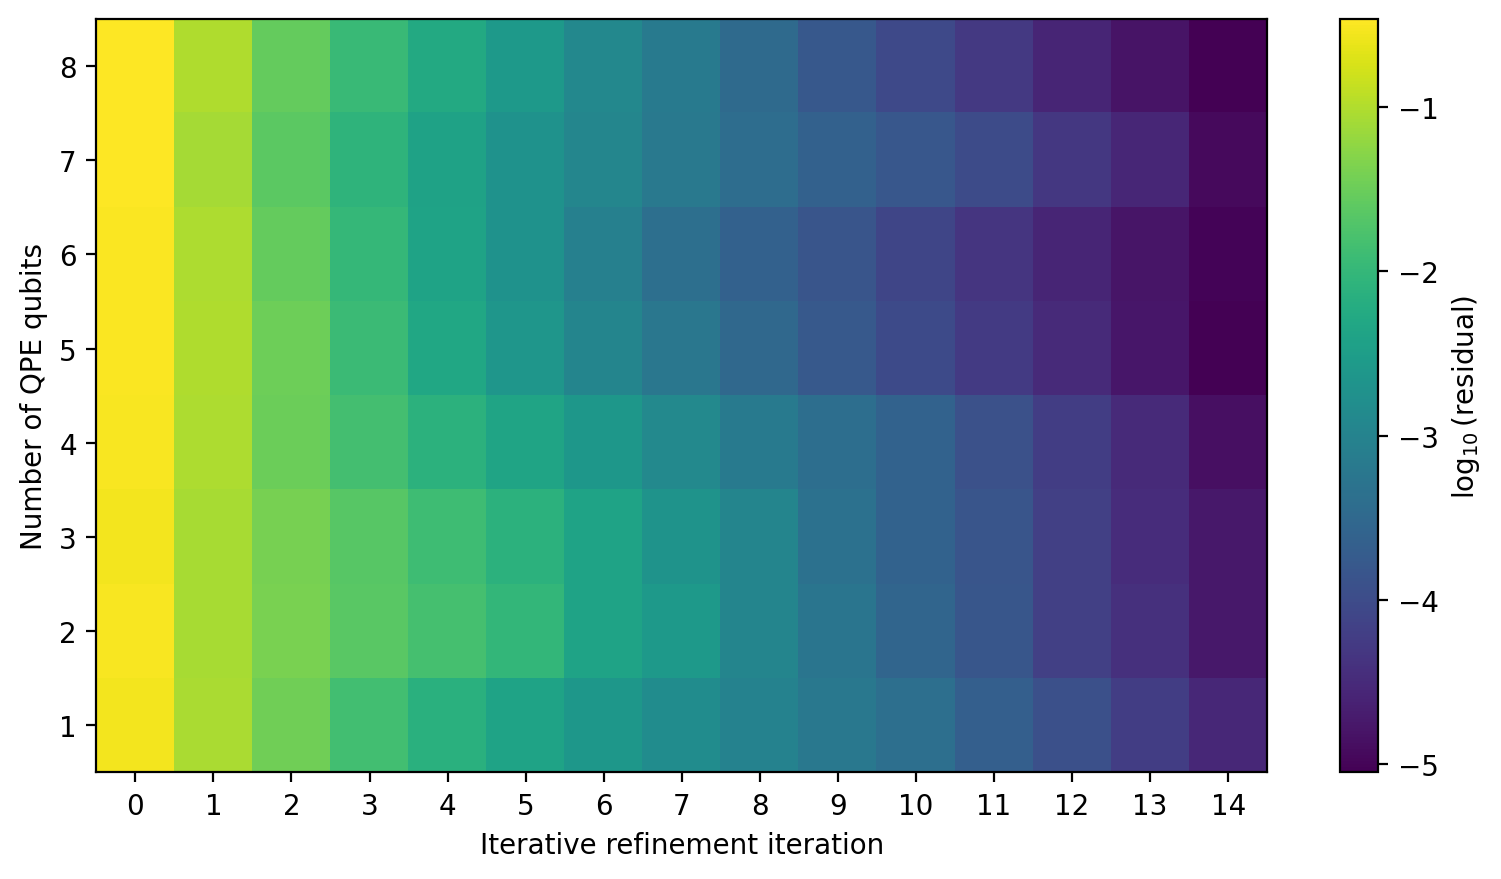

In [22]:
fig, ax = plt.subplots(figsize=(8, 4.5))
im = ax.imshow(
    log_residuals,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    interpolation="nearest",
)

ax.set_xlabel("Iterative refinement iteration")
ax.set_ylabel("Number of QPE qubits")

ax.set_xticks(np.arange(iterations))
ax.set_yticks(np.arange(max_qpe_qubits))
ax.set_yticklabels(np.arange(1, max_qpe_qubits + 1))

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\log_{10}(\mathrm{residual})$")
# cbar.set_label(r"$\mathrm{residual}$")

plt.tight_layout()
plt.show()

In [23]:
iterations = 11          # number of IR iterations to plot (0..iterations-1)
n = 64
shots = np.linspace(1, 1000, 21, dtype=int)

# rows: shot counts, cols: IR iteration
residuals = np.full((len(shots), iterations), np.nan, dtype=float)

prob = generate_problem(n=n, cond_number=5.0, sparsity=0.5, seed=0)
A, b = prob["A"], prob["b"]
A = A / np.linalg.norm(b)
b = b / np.linalg.norm(b)

num_qpe_qubits = int(math.log2(len(b)))

for i, shot_count in enumerate(shots):
    print(f"================shots: {shot_count}=================")
    solver = QuantumLinearSolver(
        qlsa=HHL(
            state_prep=StatePrep(method="default"),
            readout="measure_x",
            num_qpe_qubits=num_qpe_qubits,
            t0=2 * np.pi,
        ),
        backend=AerSimulator(),
        target_successful_shots=shot_count,
        shots_per_batch=5 * shot_count,
        optimization_level=3,
        executer=executer,
        post_processor=processor,
    )

    refiner = Refiner(A=A, b=b, solver=solver)
    refined_solution = refiner.refine(precision=1e-20, max_iter=iterations - 1, plot=False)

    r = np.asarray(refined_solution["residuals"], dtype=float)
    residuals[i, : len(r)] = r

# heatmap of log10 residuals
log_residuals = np.log10(np.maximum(residuals, 1e-16))

================shots: 1=================
IR Iteration: 0
>>> Job ID: 005deb58-aa60-45c9-bec3-95af90fffc02
>>> Job Status: DONE      
  residual: 0.9837, error: 1.2207, alpha: 0.5650

IR Iteration: 1
>>> Job ID: 0e79142c-a3cf-4039-99a4-a33644298351
>>> Job Status: DONE      
  residual: 0.9531, error: 1.1264, alpha: 0.7677

IR Iteration: 2
>>> Job ID: b24deb05-f4c4-4e75-b0ec-bb7255685b57
>>> Job Status: DONE      
  residual: 0.9467, error: 1.0435, alpha: 0.4109

IR Iteration: 3
>>> Job ID: 5c7fe297-5947-47ee-b30d-21827c75a4dc
>>> Job Status: DONE      
  residual: 0.8593, error: 0.9914, alpha: 0.8508

IR Iteration: 4
>>> Job ID: 82ba5a9d-92dc-4885-abc3-16f1f1c2a4c8
>>> Job Status: DONE      
  residual: 0.8538, error: 0.9658, alpha: 0.3543

IR Iteration: 5
>>> Job ID: a929e66c-bc3d-43ff-8052-00019c856a01
>>> Job Status: DONE      
  residual: 0.8209, error: 0.9122, alpha: 0.7234

IR Iteration: 6
>>> Job ID: e092aed8-49ec-498a-9ce8-88c98b7f13d0
>>> Job Status: DONE      
>>> Job ID: 60

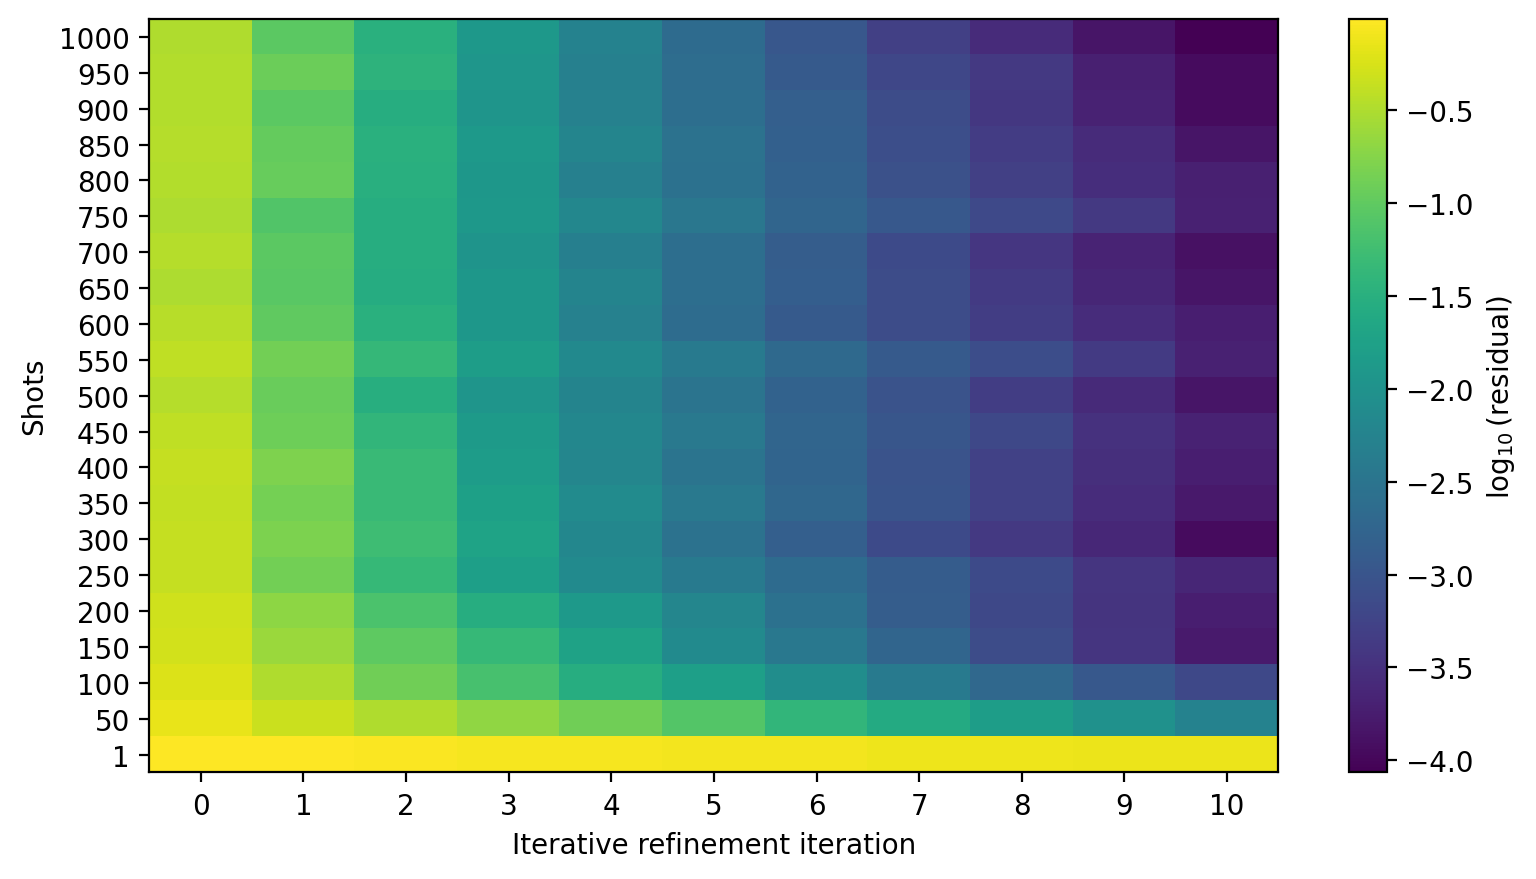

In [24]:
fig, ax = plt.subplots(figsize=(8, 4.5))
im = ax.imshow(
    log_residuals,
    origin="lower",
    aspect="auto",
    cmap="viridis",
    interpolation="nearest",
)

ax.set_xlabel("Iterative refinement iteration")
ax.set_ylabel("Shots")

ax.set_xticks(np.arange(iterations))
ax.set_yticks(np.arange(len(shots)))
ax.set_yticklabels(shots)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\log_{10}(\mathrm{residual})$")

plt.tight_layout()
plt.show()